In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import yfinance as yf 
from itertools import product 
import talib as ta
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import metrics
plt.style.use('seaborn')
import itertools
import seaborn as sns

In [2]:
def plot_conf_mat(cm, classes, title, cmap = plt.cm.Blues):                                 
    #Plot confusion matrix to see True Positives, False Positives, True Negatives and False Negatives 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    #why cm.max()  /2??
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="green" if cm[i, j] > thresh else "red", fontsize = 20)

        plt.tight_layout()
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

In [3]:
def model_evaluation(y_pred, y_test):
    c_mat = confusion_matrix(y_test, y_pred, normalize = 'all') ## Predicted vs. actual outcome
    auc = round(roc_auc_score(y_test, y_pred),4)
    accuracy = round(accuracy_score(y_test,y_pred) ,4)
    recall = round(recall_score(y_test, y_pred),4)
    precision = round(precision_score(y_test, y_pred),4)
    class_names = ['Positive', 'Negative'] ## Different class names
    plt.figure()
    fig, ax = plt.subplots(figsize=(6,4))
    plot_conf_mat(c_mat,classes=class_names,title="Confusion Matrix")
    plt.show()
    print(f"Accuracy: {accuracy}")
    print(f"Area under the curve (AUC): {auc}")
    print(f"Recall Score: {recall}")
    auc = round(roc_auc_score(y_test, y_pred), 4)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b',
    label='AUC = %0.2f'% auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



In [4]:
df = yf.download(tickers='BTC-USD', start='2015-01-01', end='2019-12-30', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


<AxesSubplot:xlabel='Date'>

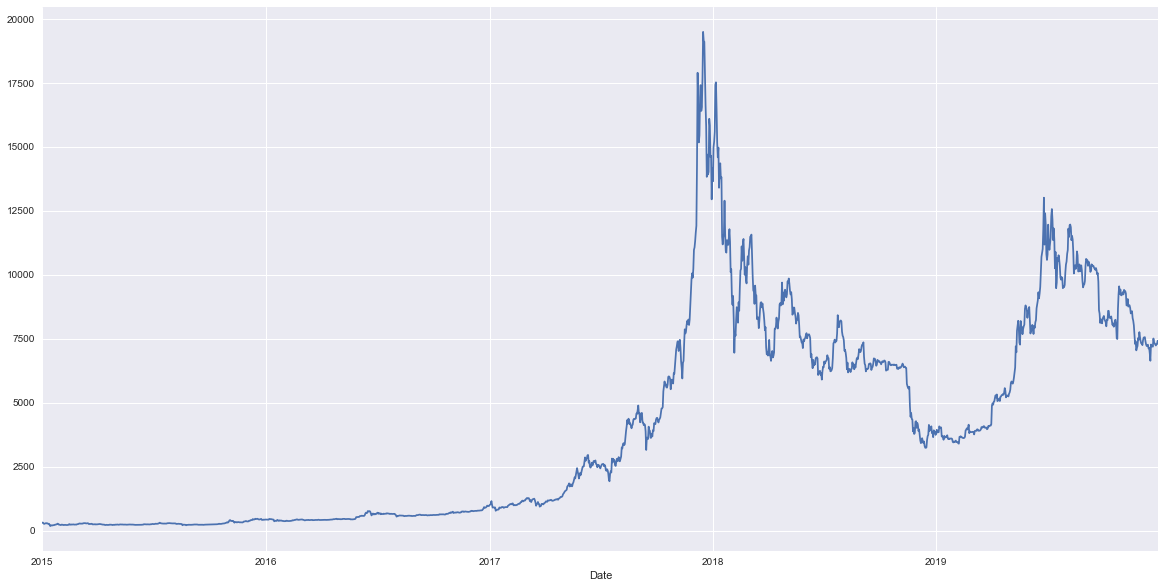

In [6]:
df.Close.plot(figsize=(20,10))

In [7]:
df['SMA_S'] = ta.SMA(df['Close'], timeperiod= 50)
df['SMA_L'] = ta.SMA(df['Close'], timeperiod= 100)

Text(0.5, 1.0, 'SMA50 | SMA100')

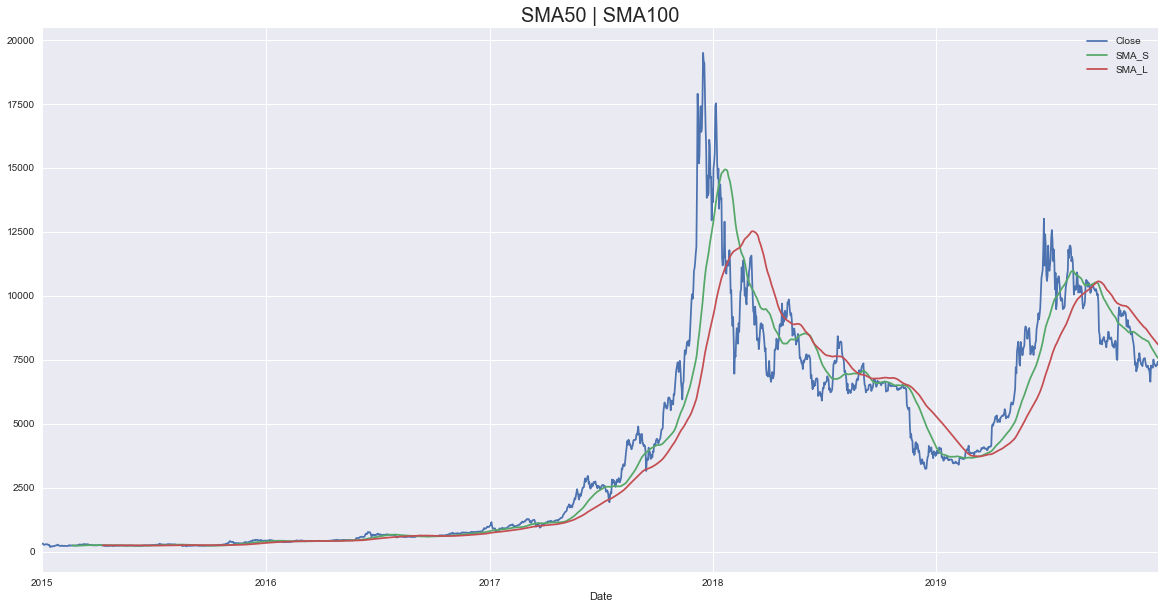

In [8]:
df[['Close', 'SMA_S', 'SMA_L']].plot(figsize=(20,10))
plt.title('SMA50 | SMA100', fontsize= 20)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2015-01-01 to 2019-12-30
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1825 non-null   float64
 1   High       1825 non-null   float64
 2   Low        1825 non-null   float64
 3   Close      1825 non-null   float64
 4   Adj Close  1825 non-null   float64
 5   Volume     1825 non-null   int64  
 6   SMA_S      1776 non-null   float64
 7   SMA_L      1726 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 128.3 KB


In [10]:
df['returns'] = np.log(df['Close']/df['Close'].shift(1))
df['target'] = np.where(df['returns'] > 0, 1, 0) 

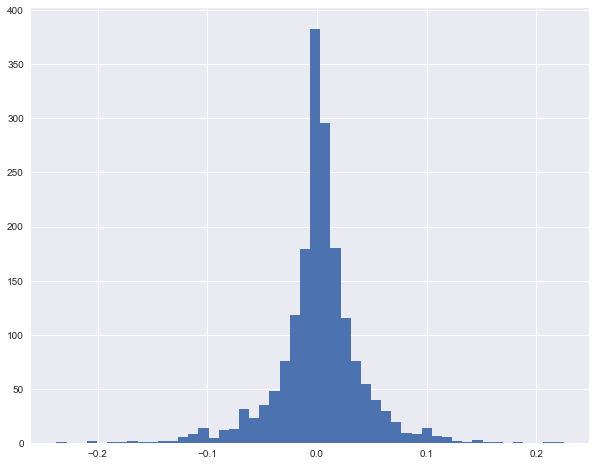

In [11]:
plt.figure(figsize = (10,8))
plt.hist(df['returns'], bins= 50);

In [12]:
def test_SMA(SMA):
    data = df.copy()
    data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
    data["SMA_S"] = data.Close.rolling(int(SMA[0])).mean()
    data["SMA_L"] = data.Close.rolling(int(SMA[1])).mean()
    data.dropna(inplace = True)
    
    data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
    data["strategy"] = data.position.shift(1) * data["returns"]
    data.dropna(inplace = True)
    
    
    return np.exp(data["strategy"].sum())

In [13]:
test_SMA((20,100))

61.96366726082787

In [14]:
SMA_S_range = range(10,50, 1)
SMA_L_range = range(100,365, 1)

In [15]:
combinations = list(product(SMA_S_range, SMA_L_range))

In [16]:
 len(combinations)

10600

In [17]:
resutls = []
for comb in combinations:
    resutls.append(test_SMA(comb))

In [18]:
resutls

[83.1738671182039,
 73.75836425894202,
 71.31103090608065,
 64.98373712291783,
 60.96157503675515,
 61.25991516024023,
 59.11011134622908,
 52.70115658286473,
 62.97211526274228,
 73.94917151540814,
 87.85097259176607,
 66.93372180224418,
 65.59602876605261,
 63.96108719498439,
 74.97621405446218,
 71.90445198378546,
 65.56966428300274,
 81.58822875915831,
 84.59026284270168,
 94.56853924843313,
 124.23668427569308,
 140.32212630521954,
 112.35576230854566,
 110.35269710030657,
 106.01737263712023,
 77.76327876606476,
 73.50631418429346,
 76.64441359910924,
 76.33400907849206,
 79.0579624434063,
 76.1155583221797,
 77.62520095021131,
 51.59159350677586,
 50.2392889120908,
 47.57681414523642,
 49.77268807353764,
 53.18997040132414,
 55.14551897223598,
 54.391358455750975,
 54.20591583867136,
 54.988228599659664,
 54.69062916354966,
 52.78193991925914,
 59.65512917992666,
 45.07660558970373,
 41.68855842069148,
 45.97575446138849,
 45.742010844319935,
 45.72168044121953,
 45.843783048795

In [19]:
np.max(resutls)

154.5360975777016

In [20]:
np.argmax(resutls)

8490

In [21]:
combinations[np.argmax(resutls)]

(42, 110)

In [22]:
all_results = pd.DataFrame(data = combinations, columns=['SMA_S', 'SMA_L'])

In [23]:
all_results

,SMA_S,SMA_L
0,10,100
1,10,101
2,10,102
3,10,103
4,10,104
...,...,...
10595,49,360
10596,49,361
10597,49,362
10598,49,363


In [24]:
all_results['performance'] = resutls

In [25]:
all_results.head()

,SMA_S,SMA_L,performance
0,10,100,83.173867
1,10,101,73.758364
2,10,102,71.311031
3,10,103,64.983737
4,10,104,60.961575


In [26]:
df

,Open,High,Low,Close,Adj Close,Volume,SMA_S,SMA_L,returns,target
Date,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,NaN,0
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,0.002489,1
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,-0.114028,0
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,-0.061959,0
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,0.038169,1
...,...,...,...,...,...,...,...,...,...,...
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,7691.141094,8198.521353,-0.004987,0
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7651.591631,8169.439756,0.007037,1
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7621.853818,8139.955508,0.003820,1


In [27]:
all_results.nlargest(10, 'performance')

,SMA_S,SMA_L,performance
8490,42,110,154.536098
8491,42,111,146.973386
7155,37,100,146.571608
7156,37,101,144.593518
8225,41,110,142.306921
9282,45,107,141.727104
21,10,121,140.322126
6893,36,103,140.123354
8489,42,109,140.001967
7420,38,100,138.957507


In [28]:
all_results.nsmallest(10, 'performance')

,SMA_S,SMA_L,performance
10333,48,363,10.027111
10598,49,363,10.027111
10334,48,364,10.176665
10599,49,364,10.176665
10596,49,361,10.268052
10597,49,362,10.281280
10595,49,360,10.404599
9524,45,349,10.429914
9262,44,352,10.468272
9263,44,353,10.497572


In [29]:
df['op_SMA_S'] = ta.SMA(df['Close'], timeperiod = 42)
df['op_SMA_L'] = ta.SMA(df['Close'], timeperiod = 110)

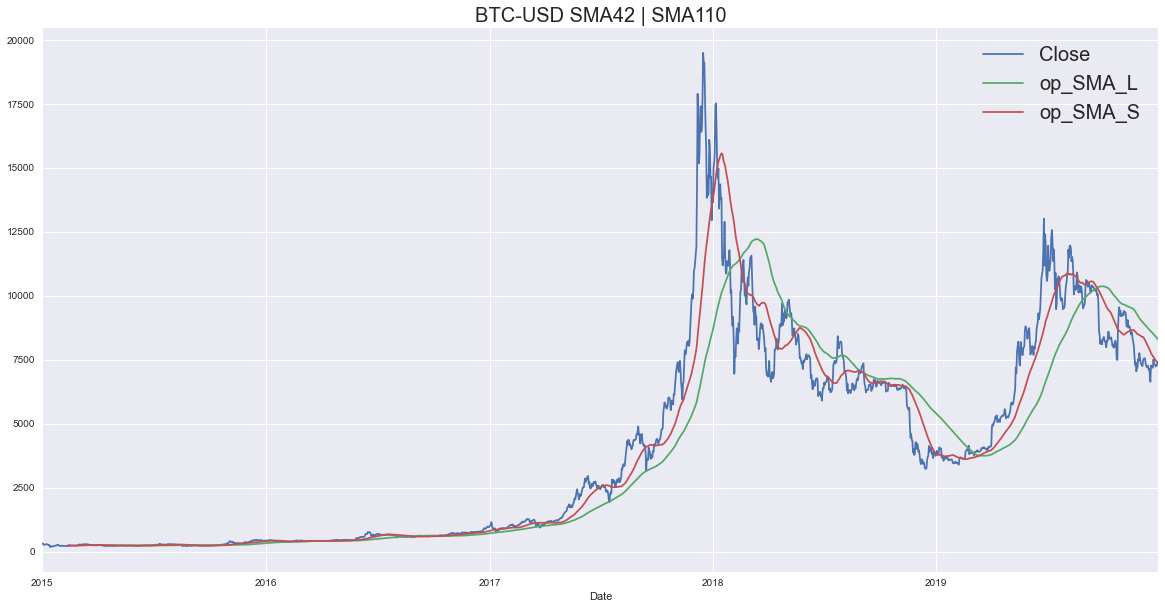

In [30]:
df[['Close', 'op_SMA_L', 'op_SMA_S']].plot(figsize=(20,10))
plt.title('BTC-USD SMA42 | SMA110', fontsize = 20)
plt.legend(fontsize =20)

In [31]:
df['Close_SMA_S'] = np.where(df['Close']> df['SMA_S'], 1, -1)
df['op_SMA_signal'] = np.where(df['op_SMA_S'] > df['op_SMA_L'], 1, -1)
df

,Open,High,Low,Close,Adj Close,Volume,SMA_S,SMA_L,returns,target,op_SMA_S,op_SMA_L,Close_SMA_S,op_SMA_signal
Date,,,,,,,,,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,NaN,NaN,0,NaN,NaN,-1,-1
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,NaN,NaN,0.002489,1,NaN,NaN,-1,-1
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,NaN,NaN,-0.114028,0,NaN,NaN,-1,-1
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,NaN,NaN,-0.061959,0,NaN,NaN,-1,-1
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,NaN,NaN,0.038169,1,NaN,NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,7691.141094,8198.521353,-0.004987,0,7464.897531,8390.156689,-1,-1
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7651.591631,8169.439756,0.007037,1,7436.280773,8361.509526,-1,-1
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7621.853818,8139.955508,0.003820,1,7406.929095,8334.082395,-1,-1


In [32]:
df.dropna(inplace=True)

In [33]:
df

,Open,High,Low,Close,Adj Close,Volume,SMA_S,SMA_L,returns,target,op_SMA_S,op_SMA_L,Close_SMA_S,op_SMA_signal
Date,,,,,,,,,,,,,,
2015-04-20,222.612000,226.350998,221.977005,224.626007,224.626007,18364700,256.895301,244.954171,0.009060,1,252.980430,248.850255,-1,1
2015-04-21,224.619995,235.268997,224.300995,235.268997,235.268997,24978000,256.087281,244.650261,0.046293,1,251.635406,248.132255,-1,1
2015-04-22,235.602005,237.908997,233.475998,234.175995,234.175995,23847900,255.136761,244.314061,-0.004657,0,250.154382,247.397201,-1,1
2015-04-23,234.052994,236.475006,233.199005,236.462006,236.462006,17036000,254.404161,244.420071,0.009715,1,248.776001,246.991564,-1,1
2015-04-24,235.970001,236.304993,229.932999,231.268005,231.268005,21448700,253.505961,244.951721,-0.022210,0,247.488644,246.692228,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,7274.799316,7388.302734,7200.386719,7238.966797,7238.966797,22787010034,7691.141094,8198.521353,-0.004987,0,7464.897531,8390.156689,-1,-1
2019-12-27,7238.141113,7363.529297,7189.934082,7290.088379,7290.088379,22777360996,7651.591631,8169.439756,0.007037,1,7436.280773,8361.509526,-1,-1
2019-12-28,7289.031250,7399.041016,7286.905273,7317.990234,7317.990234,21365673026,7621.853818,8139.955508,0.003820,1,7406.929095,8334.082395,-1,-1


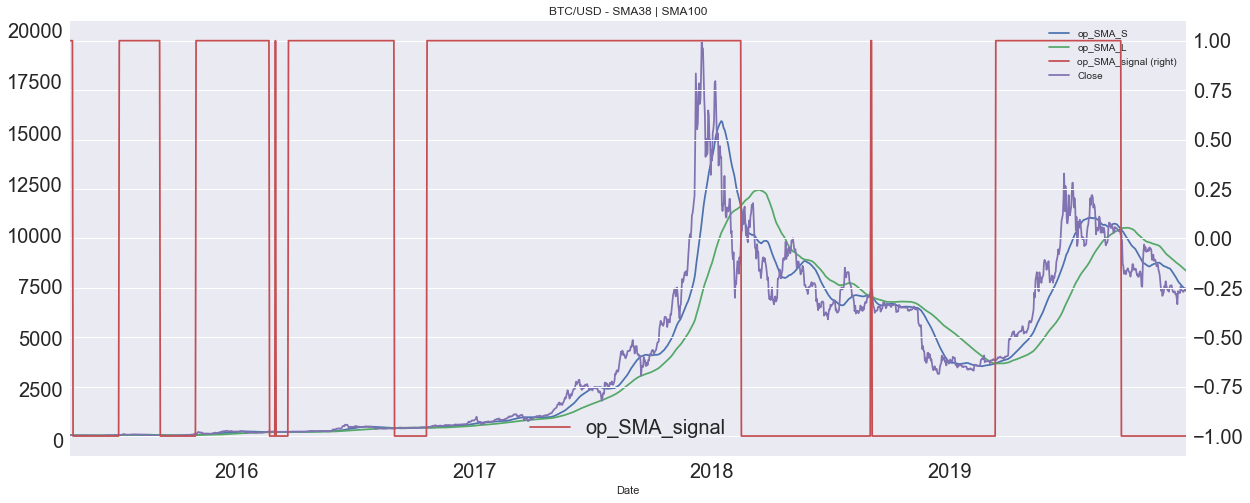

In [34]:
df.loc[:, ["op_SMA_S", "op_SMA_L", "op_SMA_signal", 'Close']].plot(figsize = (20, 8), fontsize = 20, secondary_y = "op_SMA_signal",
                                                title = "BTC/USD - SMA38 | SMA100")

plt.legend(fontsize=20)


In [35]:
X = df[['op_SMA_L', 'op_SMA_S', 'op_SMA_signal', 'Close_SMA_S']]
y = df.target

In [36]:
X.head()

,op_SMA_L,op_SMA_S,op_SMA_signal,Close_SMA_S
Date,,,,
2015-04-20,248.850255,252.980430,1,-1
2015-04-21,248.132255,251.635406,1,-1
2015-04-22,247.397201,250.154382,1,-1
2015-04-23,246.991564,248.776001,1,-1
2015-04-24,246.692228,247.488644,1,-1


In [37]:
y

Date
2015-04-20    1
2015-04-21    1
2015-04-22    0
2015-04-23    1
2015-04-24    0
             ..
2019-12-26    0
2019-12-27    1
2019-12-28    1
2019-12-29    1
2019-12-30    0
Name: target, Length: 1716, dtype: int32

<AxesSubplot:xlabel='Date'>

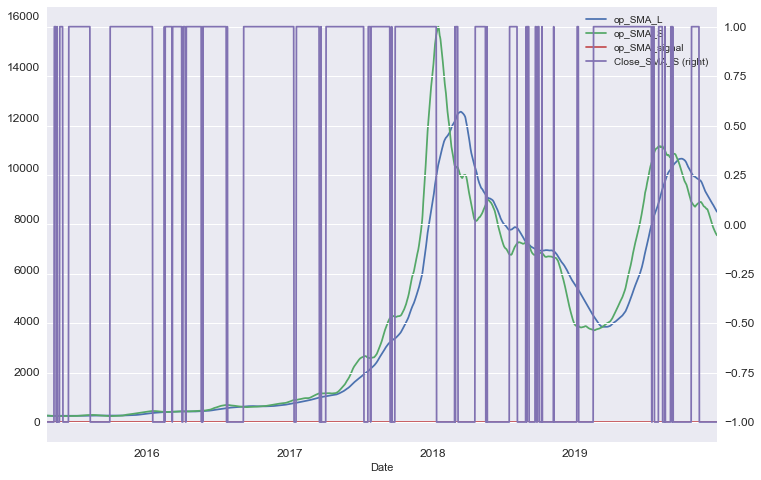

In [38]:
X.plot(figsize = (12, 8), fontsize = 12, secondary_y = "Close_SMA_S")

In [39]:
lr = LogisticRegression(C=1e6, solver='liblinear')

In [40]:
lr.fit(X, y)

LogisticRegression(C=1000000.0, solver='liblinear')

In [41]:
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag','saga']
penalty = ['l2']
c_values = [200,500,1000,100, 10, 1.0, 0.1, 0.01]
# define grid search

param_grid = dict(solver=solvers,penalty=penalty,C=c_values)
print(param_grid)

{'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'penalty': ['l2'], 'C': [200, 500, 1000, 100, 10, 1.0, 0.1, 0.01]}


In [42]:
def grid_ser(param_grid, model, X_train, y_train):

  
  
      grid = GridSearchCV(model,param_grid, cv=5, verbose = 2, n_jobs = -1)
  
      grid.fit(X_train, y_train)
  
      result = {"best_params": grid.best_params_, 'best_estimator': grid.best_estimator_, 
            'best_score':grid.best_score_ }
  
      return result
grid_ser(param_grid, lr, X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'best_params': {'C': 200, 'penalty': 'l2', 'solver': 'newton-cg'},
 'best_estimator': LogisticRegression(C=200, solver='newton-cg'),
 'best_score': 0.5571055664790834}

In [43]:
grid_ser(param_grid, lr, X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'best_params': {'C': 200, 'penalty': 'l2', 'solver': 'newton-cg'},
 'best_estimator': LogisticRegression(C=200, solver='newton-cg'),
 'best_score': 0.5571055664790834}

In [44]:
y_pred = lr.predict(X)
print(y_pred)
print(y.values)

[0 0 0 ... 0 0 0]
[1 1 0 ... 1 1 0]


<Figure size 576x396 with 0 Axes>

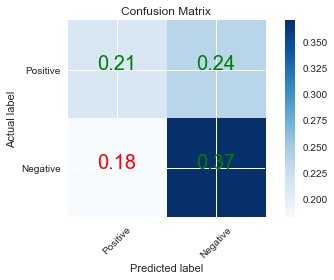

Accuracy: 0.5804
Area under the curve (AUC): 0.5699
Recall Score: 0.6698


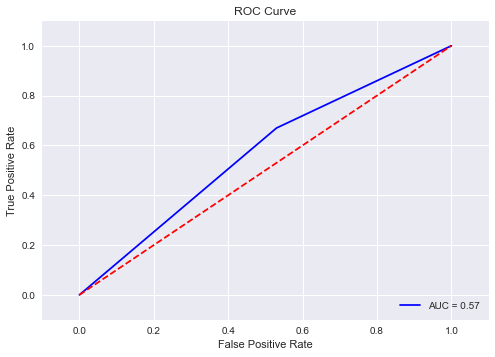

In [45]:
model_evaluation(y_pred, y)

In [46]:
DT = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=6)

In [47]:
DT.fit(X, y)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=6)

In [48]:
y_pred_dt = DT.predict(X)
print(y_pred_dt)
print(y.values)

[0 0 0 ... 0 0 0]
[1 1 0 ... 1 1 0]


<Figure size 576x396 with 0 Axes>

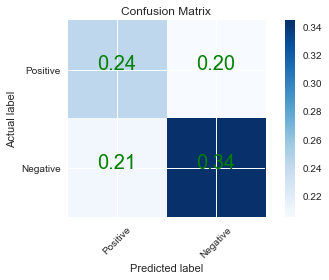

Accuracy: 0.5874
Area under the curve (AUC): 0.5832
Recall Score: 0.6234


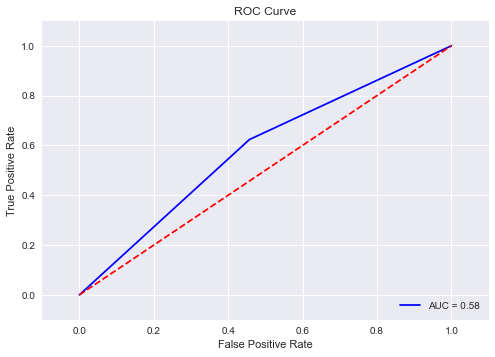

In [49]:
model_evaluation(y_pred_dt, y)

In [50]:
param_dict_dt = {"criterion": ['gini', 'entropy'],
"max_depth" : range(5,200)
}

grid_ser(param_dict_dt, DT, X, y)

Fitting 5 folds for each of 390 candidates, totalling 1950 fits


{'best_params': {'criterion': 'entropy', 'max_depth': 5},
 'best_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=6),
 'best_score': 0.5146128551088209}

In [51]:
rf = RandomForestClassifier(criterion='gini', max_depth=6)

In [52]:
rf.fit(X, y)

RandomForestClassifier(max_depth=6)

In [53]:
y_pred_rf = rf.predict(X)
print(y_pred_rf)
print(y.values)

[1 1 0 ... 1 1 1]
[1 1 0 ... 1 1 0]


<Figure size 576x396 with 0 Axes>

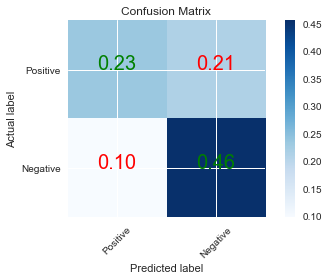

Accuracy: 0.6894
Area under the curve (AUC): 0.6736
Recall Score: 0.8238


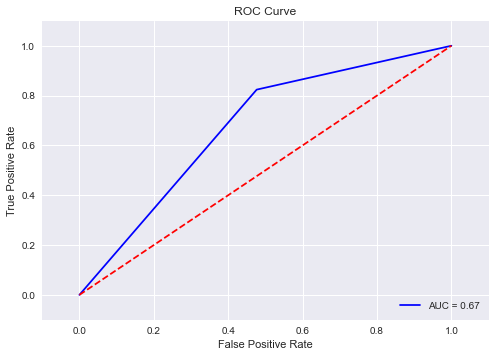

In [54]:
model_evaluation(y_pred_rf, y)

In [55]:
param_dict_rf = {"criterion": ['gini', 'entropy'],
"max_depth" : range(5,15)
}

grid_ser(param_dict_rf, rf, X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'best_params': {'criterion': 'entropy', 'max_depth': 5},
 'best_estimator': RandomForestClassifier(criterion='entropy', max_depth=5),
 'best_score': 0.5111007525933962}

In [56]:
df["lr_pred"] = lr.predict(X)
df["dt_pred"] = DT.predict(X)
df["rf_pred"] = rf.predict(X)

In [57]:
df["SMA_cross"] = df.lr_pred * df.returns
df["df_SMA_cross"] = df.dt_pred * df.returns
df["rf_SMA_cross"] = df.rf_pred * df.returns

In [58]:
df["Buy and Hold"] = df["returns"].cumsum().apply(np.exp)
df["LRTrend System"] = df["SMA_cross"].cumsum().apply(np.exp)
df["DTrend System"] = df["df_SMA_cross"].cumsum().apply(np.exp)
df["RFTrend System"] = df["rf_SMA_cross"].cumsum().apply(np.exp)

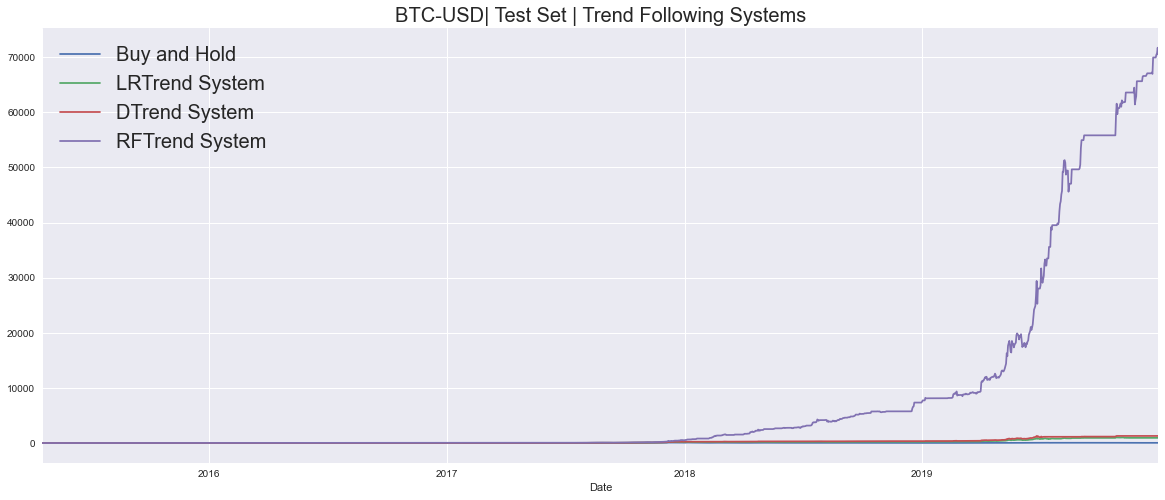

In [59]:
df[["Buy and Hold", "LRTrend System", "DTrend System", "RFTrend System"]].plot(figsize = (20 , 8))
plt.title('BTC-USD| Test Set | Trend Following Systems', fontsize= 20)
plt.legend(fontsize= 20)
plt.show()

In [60]:
df["trades"] = df.lr_pred.diff().fillna(0).abs()

In [61]:
df.trades.value_counts()

0.0    1636
1.0      80
Name: trades, dtype: int64

In [62]:
t_df = yf.download(tickers='BTC-USD', start='2020-01-01', end='2021-12-30', interval='1d')

[*********************100%***********************]  1 of 1 completed


In [63]:
t_df['returns'] = np.log(t_df['Close']/t_df['Close'].shift(1))

In [64]:
t_df['op_SMA_S'] = ta.SMA(t_df['Close'], timeperiod = 42)
t_df['op_SMA_L'] = ta.SMA(t_df['Close'], timeperiod = 110)

In [65]:
t_df['Close_SMA_S'] = np.where(t_df['Close']> t_df['op_SMA_S'], 1, -1)
t_df['op_SMA_signal'] = np.where(t_df['op_SMA_S'] > t_df['op_SMA_L'], 1, -1)
t_df

,Open,High,Low,Close,Adj Close,Volume,returns,op_SMA_S,op_SMA_L,Close_SMA_S,op_SMA_signal
Date,,,,,,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,NaN,NaN,NaN,-1,-1
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,-0.030273,NaN,NaN,-1,-1
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,0.050172,NaN,NaN,-1,-1
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275,0.008915,NaN,NaN,-1,-1
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095,0.000089,NaN,NaN,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.007500,52724.671596,53925.154545,-1,-1
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.003334,52417.113188,53966.509339,-1,-1
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-0.062151,52117.770554,53977.395099,-1,-1


In [66]:
t_df["direction"] = np.sign(t_df.returns)
t_df


,Open,High,Low,Close,Adj Close,Volume,returns,op_SMA_S,op_SMA_L,Close_SMA_S,op_SMA_signal,direction
Date,,,,,,,,,,,,
2020-01-01,7194.892090,7254.330566,7174.944336,7200.174316,7200.174316,18565664997,NaN,NaN,NaN,-1,-1,NaN
2020-01-02,7202.551270,7212.155273,6935.270020,6985.470215,6985.470215,20802083465,-0.030273,NaN,NaN,-1,-1,-1.0
2020-01-03,6984.428711,7413.715332,6914.996094,7344.884277,7344.884277,28111481032,0.050172,NaN,NaN,-1,-1,1.0
2020-01-04,7345.375488,7427.385742,7309.514160,7410.656738,7410.656738,18444271275,0.008915,NaN,NaN,-1,-1,1.0
2020-01-05,7410.451660,7544.497070,7400.535645,7411.317383,7411.317383,19725074095,0.000089,NaN,NaN,-1,-1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.007500,52724.671596,53925.154545,-1,-1,1.0
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.003334,52417.113188,53966.509339,-1,-1,-1.0
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-0.062151,52117.770554,53977.395099,-1,-1,-1.0


In [67]:
t_df.dropna(inplace= True)

In [68]:
X_test = t_df[['op_SMA_L', 'op_SMA_S', 'op_SMA_signal', 'Close_SMA_S']]
y = t_df.direction

In [69]:
t_df["pred"] = lr.predict(X_test)
t_df["DT_pred"] = DT.predict(X_test)
t_df["RF_pred"] = rf.predict(X_test)

In [70]:
t_df

,Open,High,Low,Close,Adj Close,Volume,returns,op_SMA_S,op_SMA_L,Close_SMA_S,op_SMA_signal,direction,pred,DT_pred,RF_pred
Date,,,,,,,,,,,,,,,
2020-04-19,7260.922363,7280.521973,7167.054688,7189.424805,7189.424805,31311210215,-0.009447,6556.407494,8044.745255,1,-1,-1.0,1,0,1
2020-04-20,7186.873535,7240.290527,6835.502930,6881.958496,6881.958496,37747113936,-0.043708,6531.605445,8041.852384,1,-1,-1.0,1,0,1
2020-04-21,6879.784180,6934.551758,6834.442383,6880.323242,6880.323242,32589741511,-0.000238,6507.095773,8040.896502,1,-1,-1.0,1,0,1
2020-04-22,6879.440430,7145.865723,6867.781738,7117.207520,7117.207520,33249153866,0.033850,6488.185710,8038.826713,1,-1,1.0,1,0,1
2020-04-23,7121.306152,7491.785156,7081.594727,7429.724609,7429.724609,43500782316,0.042973,6546.731817,8039.000058,1,-1,1.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.007500,52724.671596,53925.154545,-1,-1,1.0,0,0,1
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.003334,52417.113188,53966.509339,-1,-1,-1.0,0,0,1
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-0.062151,52117.770554,53977.395099,-1,-1,-1.0,0,0,1


In [71]:
t_df.pred.value_counts()

1    319
0    302
Name: pred, dtype: int64

In [72]:
t_df.DT_pred.value_counts()

1    311
0    310
Name: DT_pred, dtype: int64

In [73]:
t_df.RF_pred.value_counts()

0    360
1    261
Name: RF_pred, dtype: int64

In [74]:
lr_hits = np.sign(t_df.direction * t_df.pred).value_counts()

In [75]:
dt_hits = np.sign(t_df.direction * t_df.DT_pred).value_counts()

In [76]:
rf_hits = np.sign(t_df.direction * t_df.RF_pred).value_counts()

In [77]:
t_df["LR_strategy"] = t_df.pred * t_df.returns
t_df["DT_strategy"] = t_df.DT_pred * t_df.returns
t_df["RF_strategy"] = t_df.RF_pred * t_df.returns

In [78]:
t_df["Buy & Hold"] = t_df["returns"].cumsum().apply(np.exp)
t_df["LR_Trend System"] = t_df["LR_strategy"].cumsum().apply(np.exp)
t_df["DT_Trend System"] = t_df["DT_strategy"].cumsum().apply(np.exp)
t_df["RF_Trend System"] = t_df["RF_strategy"].cumsum().apply(np.exp)

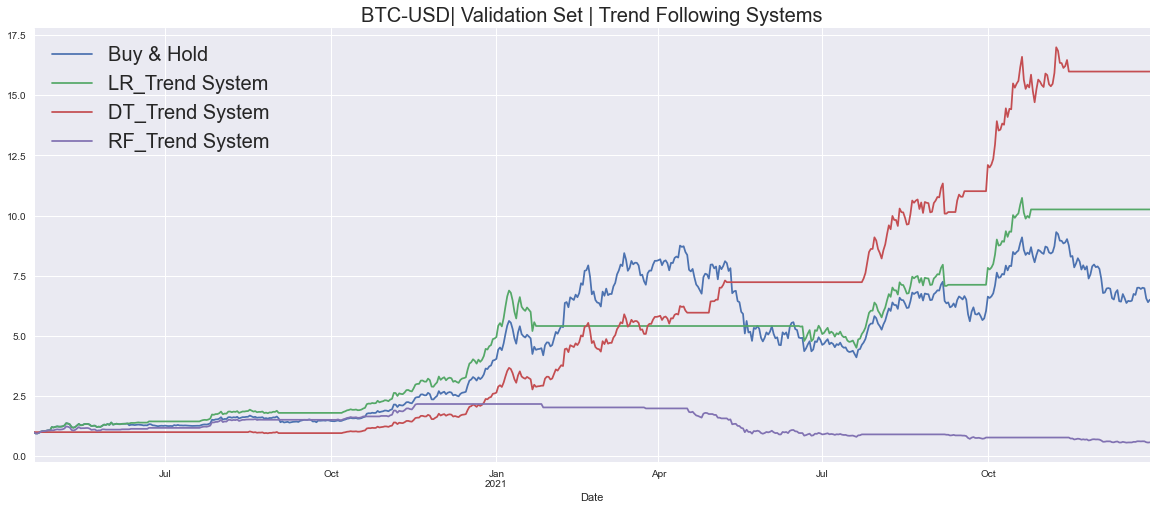

In [79]:
t_df[["Buy & Hold", "LR_Trend System", 'DT_Trend System','RF_Trend System']].plot(figsize = (20 , 8))
plt.title('BTC-USD| Validation Set | Trend Following Systems', fontsize= 20)
plt.legend(fontsize= 20)
plt.show()

<AxesSubplot:xlabel='Date'>

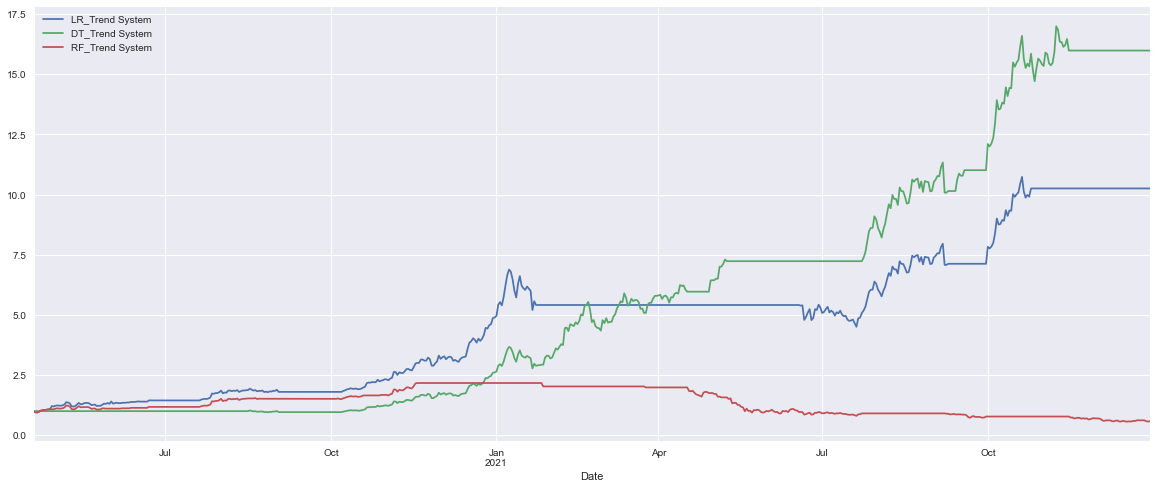

In [80]:
t_df[["LR_Trend System", 'DT_Trend System','RF_Trend System']].plot(figsize = (20 , 8))

In [81]:
LogisticRegressionReturn = t_df[["returns", "LR_Trend System"]].mean()

In [82]:
DecisionTreeReturn = t_df[["returns", "DT_Trend System"]].mean() 

In [83]:
RandomForestReturn = t_df[["returns", "RF_Trend System"]].mean() 

In [84]:
LogisticRegressionReturn

returns            0.003014
LR_Trend System    4.836435
dtype: float64

In [85]:
DecisionTreeReturn

returns            0.003014
DT_Trend System    5.761265
dtype: float64

In [86]:
RandomForestReturn

returns            0.003014
RF_Trend System    1.360462
dtype: float64

In [87]:
t_df[["returns", "RF_Trend System"]].std() * np.sqrt(365)

returns            0.710746
RF_Trend System    9.835491
dtype: float64

In [88]:
daily_return =t_df['RF_Trend System'].pct_change(1)
buy = daily_return.sum()
buy

-0.34661277382107036

In [89]:
RF_mean = daily_return.mean()/252
RF_mean

-2.218463734133835e-06

In [90]:
log_rf = np.log(t_df['RF_Trend System']/t_df['RF_Trend System'].shift(1))
log_rf.mean() * 252

-0.22041320256899777

In [91]:
std = daily_return.std()*np.sqrt(252)

In [92]:
std

0.39717322785828596

In [93]:
rfr = 187

In [94]:
shapre = (buy-rfr/100)/std

In [95]:
shapre

-5.5809722769430286

In [96]:
daily_return_DT =t_df['DT_Trend System'].pct_change(1)
buyDT = daily_return_DT.sum()
stdDT = daily_return_DT.std()*np.sqrt(252)

DTshapre = (buyDT-rfr/100)/stdDT

In [97]:
DTshapre

2.6606901037204986

In [98]:
daily_returnLR =t_df['LR_Trend System'].pct_change(1)
buyLR = daily_returnLR.sum()
stdLR = daily_returnLR.std()*np.sqrt(252)

LRshapre = (buyLR-rfr/100)/stdLR

In [99]:
LRshapre

1.6517677181973474

In [100]:
t_df

,Open,High,Low,Close,Adj Close,Volume,returns,op_SMA_S,op_SMA_L,Close_SMA_S,...,pred,DT_pred,RF_pred,LR_strategy,DT_strategy,RF_strategy,Buy & Hold,LR_Trend System,DT_Trend System,RF_Trend System
Date,,,,,,,,,,,,,,,,,,,,,
2020-04-19,7260.922363,7280.521973,7167.054688,7189.424805,7189.424805,31311210215,-0.009447,6556.407494,8044.745255,1,...,1,0,1,-0.009447,-0.0,-0.009447,0.990597,0.990597,1.000000,0.990597
2020-04-20,7186.873535,7240.290527,6835.502930,6881.958496,6881.958496,37747113936,-0.043708,6531.605445,8041.852384,1,...,1,0,1,-0.043708,-0.0,-0.043708,0.948233,0.948233,1.000000,0.948233
2020-04-21,6879.784180,6934.551758,6834.442383,6880.323242,6880.323242,32589741511,-0.000238,6507.095773,8040.896502,1,...,1,0,1,-0.000238,-0.0,-0.000238,0.948008,0.948008,1.000000,0.948008
2020-04-22,6879.440430,7145.865723,6867.781738,7117.207520,7117.207520,33249153866,0.033850,6488.185710,8038.826713,1,...,1,0,1,0.033850,0.0,0.033850,0.980647,0.980647,1.000000,0.980647
2020-04-23,7121.306152,7491.785156,7081.594727,7429.724609,7429.724609,43500782316,0.042973,6546.731817,8039.000058,1,...,1,0,1,0.042973,0.0,0.042973,1.023707,1.023707,1.000000,1.023707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.007500,52724.671596,53925.154545,-1,...,0,0,1,0.000000,0.0,0.007500,7.000807,10.252658,15.981873,0.620283
2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.003334,52417.113188,53966.509339,-1,...,0,0,1,-0.000000,-0.0,-0.003334,6.977508,10.252658,15.981873,0.618218
2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-0.062151,52117.770554,53977.395099,-1,...,0,0,1,-0.000000,-0.0,-0.062151,6.557048,10.252658,15.981873,0.580965
